In [153]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from MyModel import *
from prep_image import prep_im_and_mask
import os
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

In [244]:
df_features = pd.read_csv('feature_data.csv')
df = pd.read_csv('metadata_withmasks.csv')

df = df[df['mask']==1]
labels = df['diagnostic']

In [245]:
df_features.iloc[[69]]

,patient_id,img_id,mean_assymmetry,best_asymmetry,worst_asymmetry,red_var,green_var,blue_var,hue_var,sat_var,...,compactness,area,perimeter,convexity,F1,F2,F3,F10,F11,F12
69,PAT_1461,PAT_1461_1600_867.png,0.0802,0.0761,0.086,0.004887,0.005123,0.006126,0.0953,0.005722,...,0.2778,8420.0,617.0,0.9365,0.3616,0.3284,0.31,-0.1195,-0.1604,-0.1829


In [246]:
feature_names = ['mean_assymmetry', 'best_asymmetry', 'worst_asymmetry', 'red_var', 'green_var', 'blue_var', \
     'hue_var', 'sat_var', 'val_var', 'dom_hue', 'dom_sat', 'dom_val', \
     'compactness', 'area', 'perimeter', 'convexity', 'F1', 'F2', 'F3', 'F10', 'F11', 'F12']

In [247]:
X=df_features
y = (labels == 'BCC') | (labels == 'SCC') | (labels == 'MEL')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 41, stratify = y)

In [262]:
X_train_transformed = apply_pca(feature_selector.transform(X_train[feature_names]))
X_test_transformed = apply_pca(feature_selector.transfoX_test[feature_names])

C:\Users\idawe\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectKBest was fitted without feature names
  warnings.warn(


ValueError: X has 22 features, but SelectKBest is expecting 11 features as input.

In [251]:
from sklearn.feature_selection import SelectKBest,mutual_info_classif

In [252]:
feature_selector = SelectKBest(mutual_info_classif, k=5)
feature_selector.fit_transform(X_train_transformed, y_train)

array([[-1.08870056, -1.52458921, -0.7123015 ,  0.44253662,  0.20040938],
       [-2.33830881, -0.38093136,  0.50773308, -1.09308695, -0.03744881],
       [-0.99994051, -0.70476026,  0.09241615,  0.33677424,  0.20955509],
       ...,
       [-0.96566009,  2.82113418, -0.64923646,  0.51770256, -0.37194941],
       [-1.66790645, -0.18487079,  0.32875292, -0.12788932, -0.67979105],
       [-0.21891884,  0.09666734,  1.37219005,  0.6917239 ,  0.51230761]])

In [253]:
feature_selector.transform(X_train_transformed)

array([[-1.08870056, -1.52458921, -0.7123015 ,  0.44253662,  0.20040938],
       [-2.33830881, -0.38093136,  0.50773308, -1.09308695, -0.03744881],
       [-0.99994051, -0.70476026,  0.09241615,  0.33677424,  0.20955509],
       ...,
       [-0.96566009,  2.82113418, -0.64923646,  0.51770256, -0.37194941],
       [-1.66790645, -0.18487079,  0.32875292, -0.12788932, -0.67979105],
       [-0.21891884,  0.09666734,  1.37219005,  0.6917239 ,  0.51230761]])

In [250]:
np.shape(X_train_transformed)

(548, 11)

In [254]:
knn = KNeighborsClassifier(3)

In [255]:
knn.fit(feature_selector.transform(X_train_transformed),y_train)

KNeighborsClassifier(n_neighbors=3)

In [259]:
results_pca = knn.predict(feature_selector.transform(X_test_transformed))

In [261]:
recall_score(y_test,knn.predict(feature_selector.transform(X_test_transformed)))

0.4807692307692308

In [183]:
knn.fit(X_train[feature_names],y_train)
results = knn.predict(X_test[feature_names])

In [184]:
predictions = pd.DataFrame({'Image ID':X_test['img_id'].tolist(), 'Results':results, 'Results PCA':results_pca, 'True':y_test})

In [258]:
sum(y_test == results_pca)

94

In [193]:
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [198]:
feature_names = ['F10', 'F11', 'F12', 'convexity', 'F2', 'dom_hue', 'compactness', 'best_asymmetry']

In [234]:
feature_names = ['mean_assymmetry', 'best_asymmetry', 'worst_asymmetry', 'red_var', 'green_var', 'blue_var', \
     'hue_var', 'sat_var', 'val_var', 'dom_hue', 'dom_sat', 'dom_val', \
     'compactness', 'area', 'perimeter', 'convexity', 'F1', 'F2', 'F3', 'F10', 'F11', 'F12']


In [235]:
nca = make_pipeline(
    StandardScaler(),
    NeighborhoodComponentsAnalysis(n_components=5, random_state=0),
)

In [236]:
nca.fit(X_train[feature_names],y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('neighborhoodcomponentsanalysis',
                 NeighborhoodComponentsAnalysis(n_components=5,
                                                random_state=0))])

In [237]:
knn.fit(nca.transform(X_train[feature_names]), y_train)

KNeighborsClassifier(n_neighbors=3)

In [238]:
acc_knn = knn.score(nca.transform(X_test[feature_names]),y_test)

In [239]:
acc_knn

0.717391304347826

In [240]:
from sklearn.metrics import recall_score

In [241]:
recall_score(y_test,knn.predict(nca.transform(X_test[feature_names])))

0.5384615384615384

In [242]:
X_embedded = nca.transform(X[feature_names])

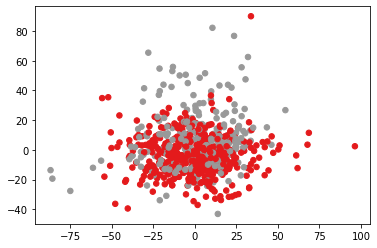

In [243]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, s=30, cmap="Set1")